In [3]:
!pip install openslide-python

     |████████████████████████████████| 338 kB 5.2 MB/s eta 0:00:01
  Created wheel for openslide-python: filename=openslide_python-1.2.0-cp39-cp39-macosx_10_9_x86_64.whl size=16069 sha256=738f0b9f03ca78e49890310c5a18bf36d9fe5dfd18b2d0de4a0b1d0e4d65ad8e
  Stored in directory: /Users/dani/Library/Caches/pip/wheels/ad/84/69/1b8062b5e72d19f9fc3586e1946ee99ea65403e3133ecad1f5
Successfully built openslide-python


In [29]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
import cv2 
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [30]:
train_df = pd.read_csv("train.csv")

In [31]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [32]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "./resized_method_2/resized_" + x + ".jpg")

In [33]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path
0,006388_0,11,006388,0,CE,./resized_method_2/resized_006388_0.jpg
1,008e5c_0,11,008e5c,0,CE,./resized_method_2/resized_008e5c_0.jpg
2,00c058_0,11,00c058,0,LAA,./resized_method_2/resized_00c058_0.jpg
3,01adc5_0,11,01adc5,0,LAA,./resized_method_2/resized_01adc5_0.jpg
4,026c97_0,4,026c97,0,CE,./resized_method_2/resized_026c97_0.jpg


In [34]:
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)

In [35]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,./resized_method_2/resized_006388_0.jpg,1
1,008e5c_0,11,008e5c,0,CE,./resized_method_2/resized_008e5c_0.jpg,1
2,00c058_0,11,00c058,0,LAA,./resized_method_2/resized_00c058_0.jpg,0
3,01adc5_0,11,01adc5,0,LAA,./resized_method_2/resized_01adc5_0.jpg,0
4,026c97_0,4,026c97,0,CE,./resized_method_2/resized_026c97_0.jpg,1


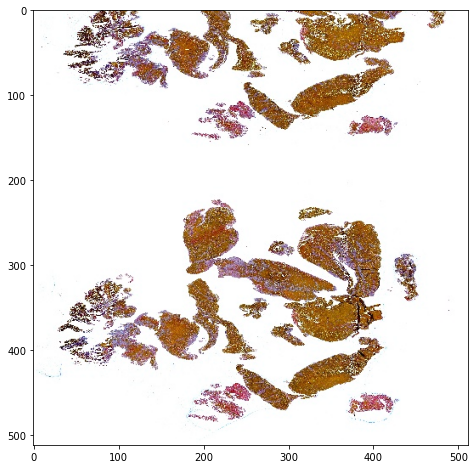

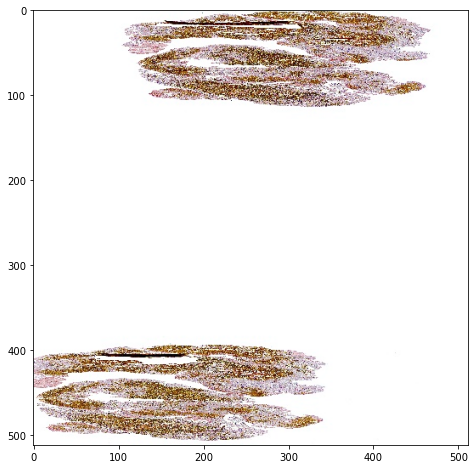

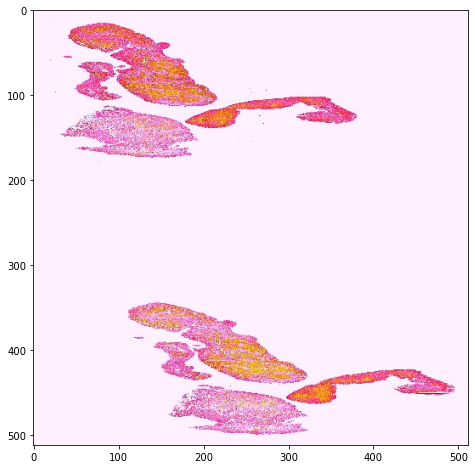

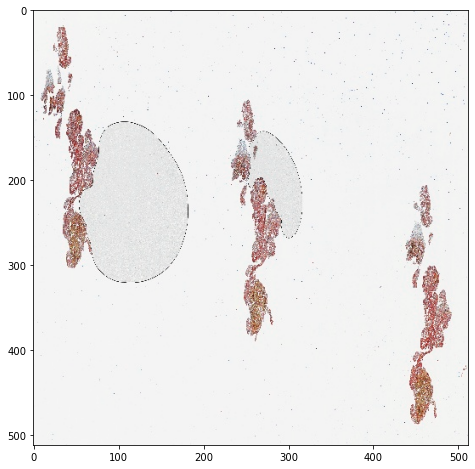

CPU times: user 945 ms, sys: 21.2 ms, total: 966 ms
Wall time: 976 ms


In [36]:
%%time
sample_train = train_df[:4]
for i in range(4):
    image = cv2.imread(train_df['file_path'].get(i))
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.show()  
    del image
    gc.collect()

In [80]:
def image_processing(path):
    image = cv2.resize(cv2.imread(path), (512,512))
    image = np.array(image)
    return image

x_train = []
labels = []
for path in tqdm(train_df['file_path']):
    image = image_processing(path)
    x_train.append(image)
    
for label in tqdm(train_df["target"]):
    labels.append(label)
    
#x_train=np.array(x_train)
y_train=train_df['target']
    
x_train = np.array(x_train)
x_train = x_train.astype('float32') / 255.0
y_train=train_df['target']

100%|████████████████████████████████████| 754/754 [00:00<00:00, 1689372.44it/s]


In [81]:
model = Sequential()
input_shape = (512, 512, 3)

model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Flatten())
#model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.5))

model.add(Dense(1, "sigmoid"))

#model.compile(optimizer=tf.keras.optimizers.SGD(),
#               loss='binary_crossentropy',
#               metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), 
             tf.keras.metrics.BinaryAccuracy(name="accuracy"),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
    optimizer = tf.keras.optimizers.Adam(1e-4))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 flatten_9 (Flatten)         (None, 131072)            0         
                                                                 
 dense_18 (Dense)            (None, 128)               16777344  
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                

In [82]:
#x_train=np.array(x_train)
#y_train=train_df['target']

x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.3, random_state=0)
print(len(x_train))
print(len(y_train))

#X_train, X_val, y_train, y_val = train_test_split(x_train,y_train, 
#                                                  test_size=0.2, random_state=0)

print(y_train[:10])

527
527
579    0
584    1
315    1
200    1
319    0
538    1
454    1
12     1
161    1
247    1
Name: target, dtype: int64


In [83]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        self.metrics["loss"]=[]
        self.metrics["val_loss"]=[]
        self.metrics["accuracy"]=[]
        self.metrics["val_accuracy"]=[]
        self.metrics["lr"]=[]
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
        
        # Plotting
        metrics = [x for x in logs if x in self.metrics and "val" not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                    self.metrics[metric], 
                    label=metric)
            if metric != "lr" and logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()
            if metric == "lr":
                axs[i].set_ylim(bottom=0, top=0.0015)
            else:
                axs[i].set_ylim(bottom=0, top=1)

        plt.tight_layout()
        plt.show()

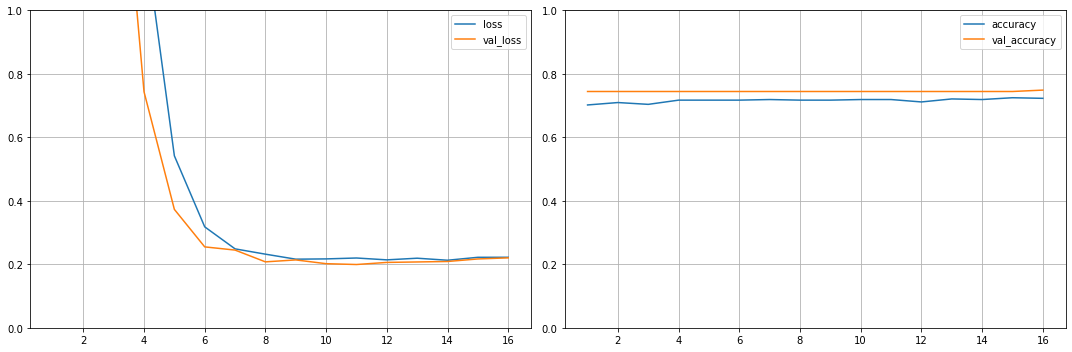

17/17 [==============================] - 15s 903ms/step - loss: 0.2222 - rmse: 0.4358 - accuracy: 0.7230 - precision_8: 0.7248 - recall_8: 0.9894 - val_loss: 0.2204 - val_rmse: 0.4325 - val_accuracy: 0.7489 - val_precision_8: 0.7545 - val_recall_8: 0.9822
CPU times: user 17min 46s, sys: 4min 12s, total: 21min 58s
Wall time: 4min


In [84]:
%%time

import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback

def step_decay(epoch):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)

history = model.fit(
    x_train,
    y_train,
    epochs = 20,
    batch_size=32,
    validation_data = (x_test,y_test),
    verbose = 1,
    callbacks = [PlotLearning(), earstop],
    shuffle = True
)

In [85]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

8/8 [==============================] - 2s 180ms/step - loss: 0.2204 - rmse: 0.4325 - accuracy: 0.7489 - precision_8: 0.7545 - recall_8: 0.9822
Test loss: 0.2203713357448578
Test accuracy: 0.4325196444988251


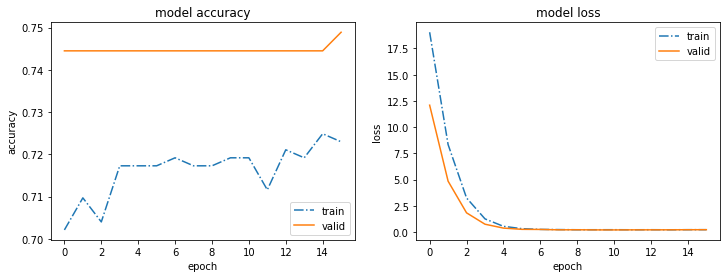

In [86]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')


In [87]:
def show_metrics(y_pred,th):
    cm = confusion_matrix(y_test, y_pred>th)
    print("Y_TEST", y_test)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LAA", "CE"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    d = classification_report(y_test, y_pred > th,output_dict=True)
    display(pd.DataFrame.from_dict(d))
    return y_pred

Y_TEST 648    1
711    1
404    1
79     1
422    1
      ..
250    1
457    1
625    1
155    1
272    1
Name: target, Length: 227, dtype: int64
[[  4  54]
 [  3 166]]


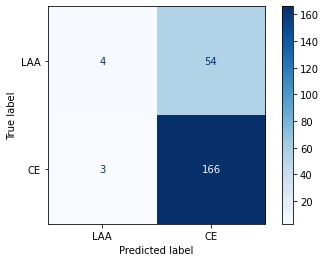

,0,1,accuracy,macro avg,weighted avg
precision,0.571429,0.754545,0.748899,0.662987,0.707758
recall,0.068966,0.982249,0.748899,0.525607,0.748899
f1-score,0.123077,0.853470,0.748899,0.488274,0.666850
support,58.000000,169.000000,0.748899,227.000000,227.000000


array([[0.7176309 ],
       [0.73547417],
       [0.7310858 ],
       [0.587412  ],
       [0.702631  ],
       [0.66691744],
       [0.74158865],
       [0.79074925],
       [0.72478074],
       [0.6588385 ],
       [0.69636405],
       [0.7199341 ],
       [0.79674304],
       [0.58676904],
       [0.7289139 ],
       [0.7876369 ],
       [0.5833409 ],
       [0.70010275],
       [0.7128938 ],
       [0.72552145],
       [0.7509428 ],
       [0.7541721 ],
       [0.72056377],
       [0.6670972 ],
       [0.4515938 ],
       [0.7537849 ],
       [0.6009191 ],
       [0.673801  ],
       [0.72015274],
       [0.69280636],
       [0.62767005],
       [0.56543964],
       [0.7986289 ],
       [0.70807755],
       [0.6666667 ],
       [0.71427155],
       [0.65224504],
       [0.80298007],
       [0.7251257 ],
       [0.7202231 ],
       [0.73942363],
       [0.63352466],
       [0.71657765],
       [0.7224597 ],
       [0.6650827 ],
       [0.6983404 ],
       [0.691726  ],
       [0.750

In [88]:
y_pred = model.predict(x_test)
show_metrics(y_pred,.5)